# Setup

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from unet_clonable import *
from diffusion_model import *
import math
import numpy as np
import matplotlib.pyplot as plt

C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters

In [2]:
# architecture of attention unet
image_size = 64
widths = [32, 64, 96, 128]
block_depth = 2
diffusion_steps = 250

# optimization
batch_size = 64
learning_rate = 1e-3
weight_decay = 1e-4
checkpoint_path = "checkpoints/diffusion_model/diffusion_steps_%d_chanel%d_attention_%d"%(diffusion_steps,max(widths),min(Attn_resolutions))

#other hyperparameters of model are stored at diffusion_model.py

# Data Pipeline

In [3]:
# load dataset
#could setting in diffusion model.py
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# Training

Epoch 1/100
511/511 [==============================] - 154s 283ms/step - n_loss: 0.2086 - i_loss: 0.2403 - val_n_loss: 0.1348 - val_i_loss: 0.0908 - val_kid: 2.2219


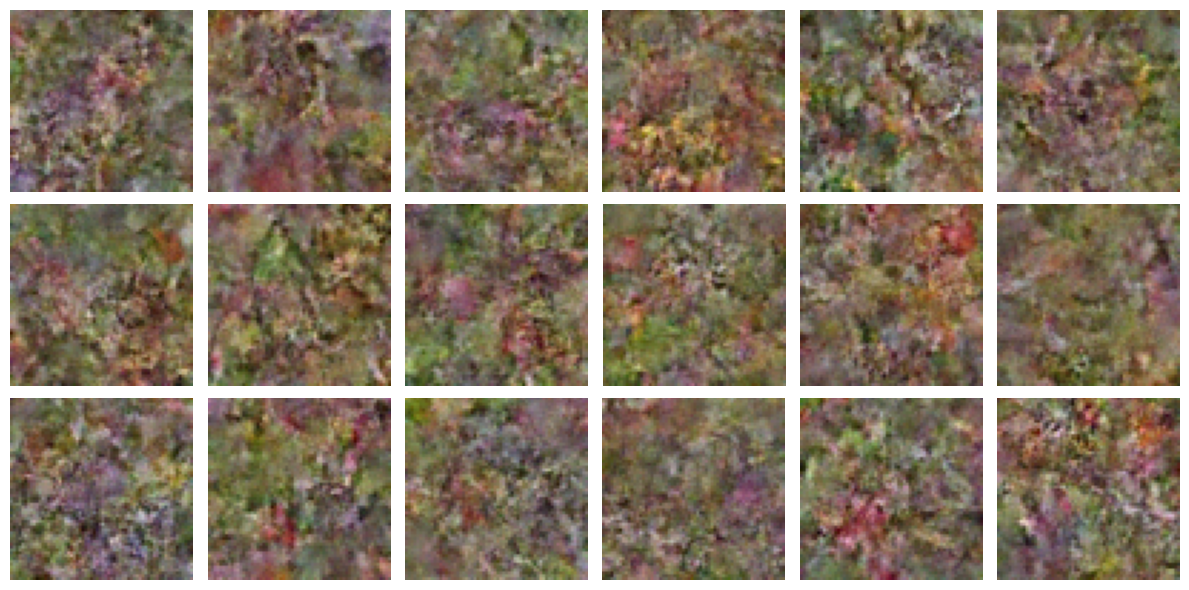

Epoch 2/100
 95/511 [====>.........................] - ETA: 1:07 - n_loss: 0.1292 - i_loss: 0.0817

KeyboardInterrupt: 

In [4]:
model = DiffusionModel(image_size, widths, block_depth, diffusion_steps)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, 
        weight_decay=weight_decay),
    loss=keras.losses.MeanSquaredError(),  # pixelwise mean absolute error is used as loss, mse also ok
)

# save the best model based on the validation KID metric
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)
#model.load_weights(checkpoint_path)
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

# inference

In [ ]:
model2 = DiffusionModel(image_size, widths, block_depth, diffusion_steps)
model2.normalizer.adapt(train_dataset)
model2.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay),
    loss=keras.losses.mean_absolute_error,  # pixelwise mean absolute error is used as loss, mse also ok
)


In [ ]:
# load the best model and generate images
model2.load_weights(checkpoint_path)

In [ ]:
model2.plot_images(plot_diffusion_steps = int(0.999*diffusion_steps), epoch=0)